# Final Project - Interconnect Churn Analysis
***
## Intro

In this project, I will be analysing data for the telecom operator Interconnect, for the purpose of forcasting the churn rate of current clients. The company would like to predict which users are likely to stop using their services in order to offer those customers promotions and special plan options, to maintain brand loyalty. 

**Some notes about the dataset provided by Interconnect:**
- The contract information is valid as of February 1, 2020.
- The data consists of files obtained from different sources:
    - `contract.csv` — contract information
    - `personal.csv` — the client's personal data
    - `internet.csv` — information about Internet services
    - `phone.csv` — information about telephone services
- In each file, the column `customerID` contains a unique code assigned to each client.

To begin, we will carry out a few preliminary data preprocessing steps spelled out in the [Project Plan](https://tripleten.com/trainer/data-scientist/lesson/51136d69-0af7-41f3-897f-018938ced1cc/jupyter-homework/?theory_open=false) including:
- Editing column names to snake_script for ease of reading and to maintain consistency when the data is merged.
- Editing column dtypes.
- One-Hot Encoding(OHE) / Ordinal Encoding for Machine Learning purposes.
- Feature Engineering.
- Merging data into one final pandas DataFrame.

Then Exploratory Data Analysis will be preformed to examine the data as presented in order to identify patterns and/or trends. 

Once the data has been analysed and prepared for the models, we will train multiple models to verify the most accurate approach is taken. Each model will be trained using the same instance of the KFold cross validation class, using GridSearchCV to ensure optimal hyperparameter tuning. The models include:

- Dummy Classifier (Sanity Check)
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- LightGBM Classifier
- CatBoost Classifier

The metrics that have been selected for use will be:

Primary metric: Area Under Curve - Recieving Operator Characteristic (AUC-ROC)
- Target: 0.80 
    - Additional Target: 0.85 

Additional metric: Accuracy

## Initialization

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
data_path = 'D://Code/FinalProject/final_provider/'

# Local files
try: 
    contract = pd.read_csv(data_path + 'contract.csv')
    internet = pd.read_csv(data_path + 'internet.csv')
    personal = pd.read_csv(data_path + 'personal.csv')
    phone = pd.read_csv(data_path + 'phone.csv')
    
# On Platform Files
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
    
finally:
    print('Datasets Loaded')

Datasets Loaded


## Preprocessing

### Contract dataset

Editing column names to snake_script, editing dtypes, preforming OHE on `paperless_billing` column.

In [3]:
# Changing column names
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']

# Editing dtypes
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# Encode 'paperless_billing' column
contract['paperless_billing'] = pd.get_dummies(contract['paperless_billing'], drop_first=True, dtype='int')

contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65


The columns `type` and `payment_method` contain valuable data for EDA and will be encoded using the `OrdinalEncoder` class later before the final merge.

Converting the `total_charges` column has introduced missing values.

In [4]:
# Displaying and filling missing values
display(contract[contract['total_charges'].isna()])
contract = contract.fillna(0)
contract.isna().sum()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,NaN


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

We can see that all entries missing the `total_charges` column have a begin date of `2020-02-01`, when the data was collected, therefore the missing values can easily be filled with 0 as the customers have not been charged.

The last preprocessing steps for this data will be calculating each customers tenure, separate from the data as this coulmn would cause leakage. Using the tenure Series we create an `over_charges` column that calculates how the `total_charges` column tracks against the `monthly_charges` column. 

In [5]:
# Creating tenure variable then calculating 'over_charges'
tenure = ((pd.to_datetime(contract['end_date'].replace('No', max(contract['begin_date']))) - contract['begin_date']) / np.timedelta64(1, 'M'))
tenure = tenure.round().astype('int')
contract['over_charges'] = contract['total_charges'] - (contract['monthly_charges'] * tenure)
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,over_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0.00
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,-46.80
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,0.45
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,-62.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,10.25


Finally, the `churn` column is created that will serve as the target column for the machine learning algorithms and checking for duplicate entries. 

In [6]:
# Creating 'churn' column
contract['churn'] = (contract['end_date'] != 'No').astype('int')
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   over_charges       7043 non-null   float64       
 9   churn              7043 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 550.4+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,over_charges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0.00,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,-46.80,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,0.45,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,-62.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,10.25,1


In [7]:
# Duplicates
print(contract.duplicated().sum())
print(contract['customer_id'].duplicated().sum())

0
0


### Internet Dataset

Editing column names to snake_script, preforming OHE on boolean columns. Creating `has_internet` column to indicate which users are in this dataset.

In [8]:
# Changing column names
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# Preforming OHE
internet[internet.columns[2:]] = pd.get_dummies(internet[internet.columns[2:]], drop_first=True, dtype='int')

# Creating 'has_internet'
internet['has_internet'] = np.ones(shape=internet.shape[0]).astype('int')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
 8   has_internet       5517 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 388.0+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,has_internet
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1


The `internet_service` column contains valuable data for EDA and will be encoded later with other columns.

Checking for duplicates.

In [9]:
# Duplicates
print(internet.duplicated().sum())
print(internet['customer_id'].duplicated().sum())

0
0


### Personal Dataset
Editing column names to snake_script, preforming OHE on boolean columns. Creating `separated` column using `partner` and `dependents` columns.

In [10]:
# Changing column names
personal.columns = ['customer_id', 'gender_male', 'senior_citizen', 'partner', 'dependents']

# Preforming OHE
personal[personal.columns[2:]] = pd.get_dummies(personal[personal.columns[2:]], drop_first=True, dtype='int')

# Preforming OHE on gender column separately due to issues when running together
personal['gender_male'] = pd.get_dummies(personal['gender_male'], drop_first=True, dtype='int')

# Creating 'separated'
personal['separated'] = ((personal['partner'] == 0) & (personal['dependents'] == 1)).astype('int')
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender_male     7043 non-null   int64 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
 5   separated       7043 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 330.3+ KB


,customer_id,gender_male,senior_citizen,partner,dependents,separated
0,7590-VHVEG,0,0,1,0,0
1,5575-GNVDE,1,0,0,0,0
2,3668-QPYBK,1,0,0,0,0
3,7795-CFOCW,1,0,0,0,0
4,9237-HQITU,0,0,0,0,0


Checking for duplicates.

In [11]:
# Duplicates
print(personal.duplicated().sum())
print(personal['customer_id'].duplicated().sum())

0
0


### Phone Dataset
Editing column names to snake_script, preforming OHE on `multiple_lines`. Create `phone_service` column to indicate which users are in this dataset.

In [12]:
# Changing column names
phone.columns = ['customer_id', 'multiple_lines']

# Preforming OHE
phone['multiple_lines'] = pd.get_dummies(phone['multiple_lines'], drop_first=True, dtype='int')

# Creating 'phone_service'
phone['phone_service'] = np.ones(shape=phone.shape[0]).astype('int')
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
 2   phone_service   6361 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 149.2+ KB


,customer_id,multiple_lines,phone_service
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


Checking for duplicates.

In [13]:
# Duplicates
print(phone.duplicated().sum())
print(phone['customer_id'].duplicated().sum())

0
0


## EDA
<a id='eda'></a>
Now with the data processed, Exploratory Data Analysis will be preformed to allow insight on trends in the data and indicate best practices Interconnect could take when planning how to retain customer loyalty. 

First the data will all be put into one table and all missing values will be marked 0 to indicate users do not have services.

In [14]:
# Merging data
EDA_df = contract.merge(internet, how='left', on='customer_id').merge(personal, how='left', on='customer_id').merge(phone, how='left', on='customer_id')
EDA_df = EDA_df.fillna(0)
EDA_df.info()
EDA_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   over_charges       7043 non-null   float64       
 9   churn              7043 non-null   int64         
 10  internet_service   7043 non-null   object        
 11  online_security    7043 non-null   float64       
 12  online_backup      7043 non-null   float64       
 13  device_protection  7043 non-null   float64       
 14  tech_sup

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,over_charges,churn,...,streaming_tv,streaming_movies,has_internet,gender_male,senior_citizen,partner,dependents,separated,multiple_lines,phone_service
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0.00,0,...,0.0,0.0,1.0,0,0,1,0,0,0.0,0.0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,-46.80,0,...,0.0,0.0,1.0,1,0,0,0,0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,0.45,1,...,0.0,0.0,1.0,1,0,0,0,0,0.0,1.0
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,-62.75,0,...,0.0,0.0,1.0,1,0,0,0,0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,10.25,1,...,0.0,0.0,1.0,0,0,0,0,0,0.0,1.0


### Loyalty Comparisons
The first few graphs will compare each of the `total_charges`, `monthly_charges`, `over_charges` columns and the tenure variable created during preprocessing. 


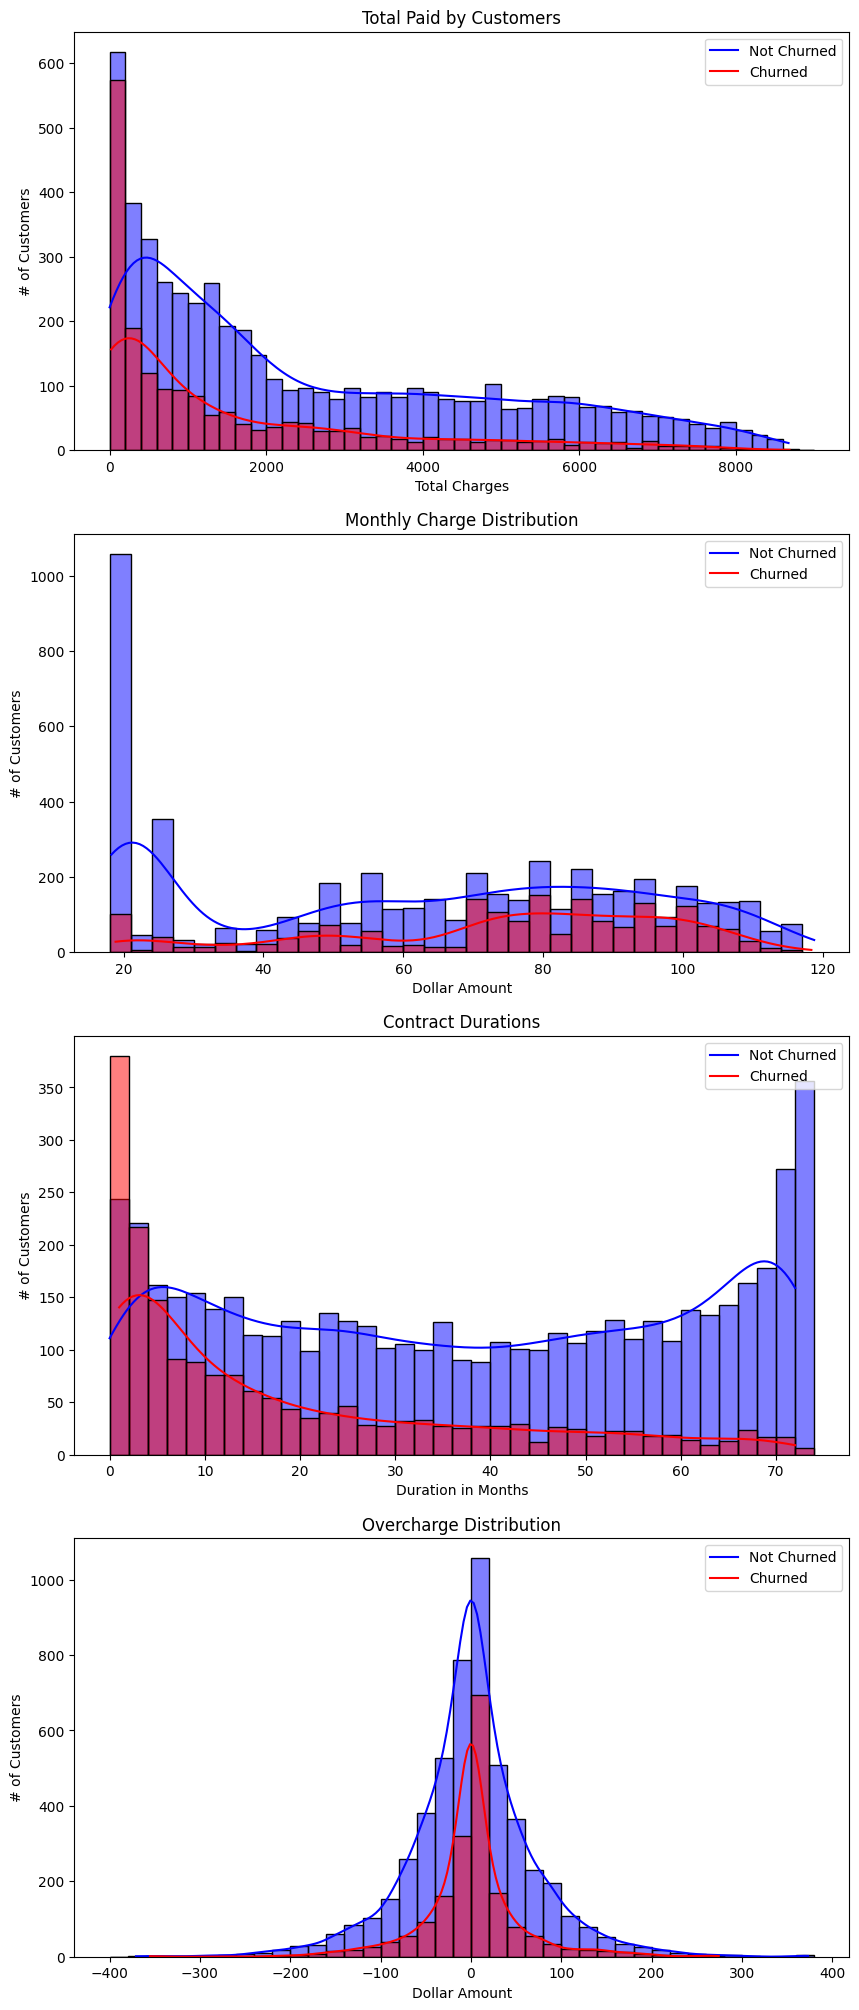

In [15]:
# Creating separate table for plotting purposes
churn = EDA_df[EDA_df['churn']==1].reset_index(drop=True)
not_churn = EDA_df[EDA_df['churn']==0].reset_index(drop=True)

# Plotting
plt.subplots(4, 1, figsize=(10, 25))

# Total_Charges Plot
plt.subplot(4,1,1)
total_bins = np.arange(0, 9001, 200)
sns.histplot(not_churn['total_charges'], kde=True, bins=total_bins, color='blue')
sns.histplot(churn['total_charges'], kde=True, bins=total_bins, color='red')
plt.title('Total Paid by Customers')
plt.xlabel('Total Charges')
plt.ylabel('# of Customers')
plt.legend(loc='upper right', labels=['Not Churned', 'Churned'])

# Monthly_Charges Plot
plt.subplot(4,1,2)
monthly_bins = np.arange(18, 120, 3)
sns.histplot(not_churn['monthly_charges'], kde=True, bins=monthly_bins, color='blue')
sns.histplot(churn['monthly_charges'], kde=True, bins=monthly_bins, color='red')
plt.title('Monthly Charge Distribution')
plt.xlabel('Dollar Amount')
plt.ylabel('# of Customers')
plt.legend(loc='upper right', labels=['Not Churned', 'Churned'])

# Tenure Plot
plt.subplot(4,1,3)
tenure_bins = np.arange(0, 76, 2)
sns.histplot(tenure.where(EDA_df['churn']==0), kde=True, bins=tenure_bins, color='blue')
sns.histplot(tenure.where(EDA_df['churn']==1), kde=True, bins=tenure_bins, color='red')
plt.title('Contract Durations')
plt.xlabel('Duration in Months')
plt.ylabel('# of Customers')
plt.legend(loc='upper right', labels=['Not Churned', 'Churned'])

# Over_Charges Plot
plt.subplot(4,1,4)
overcharge_bins = np.arange(-400, 400, 20)
sns.histplot(not_churn['over_charges'], kde=True, bins=overcharge_bins, color='blue')
sns.histplot(churn['over_charges'], kde=True, bins=overcharge_bins, color='red')
plt.title('Overcharge Distribution')
plt.xlabel('Dollar Amount')
plt.ylabel('# of Customers')
plt.legend(loc='upper right', labels=['Not Churned', 'Churned'])

plt.show()

<a id='loyalty'></a>

**Total Paid:**
- Both set of users are skewed to the right, with the majority of users having only spent <=1000.
- Not Churned has more users that can be considered outliers, where customers who have churned tend not to spend as much.

**Monthly Charge:**
- Not churned dataset is bimodal, one mode near \\$20 and the other around \\$90.
- Churned users do not have the same trend, indicating a major difference between the classes.

**Tenure:**
- Churned users are skewed to the right where Not Churned has an even spread with peaks at either end, indicating that while both sets of users have many newer users, the churned dataset shows users with great brand loyalty. 
    - This can help explain the previous graph's difference. Customers that have better monthly prices are more likely to maintain brand loyalty.
- Churned users tend to churn within 6 months, leaving a small window for promotional material.

**Overcharge:**
- Interestingly, both datasets seem to have a similar distribution in this column, almost contrary to the other graphs.

### Services and Demograpics Comparison

Both datasets will be compared to the dataset as a whole on the percentage of users that have each of Interconnect's services, and on other points of relevant demograpic data.

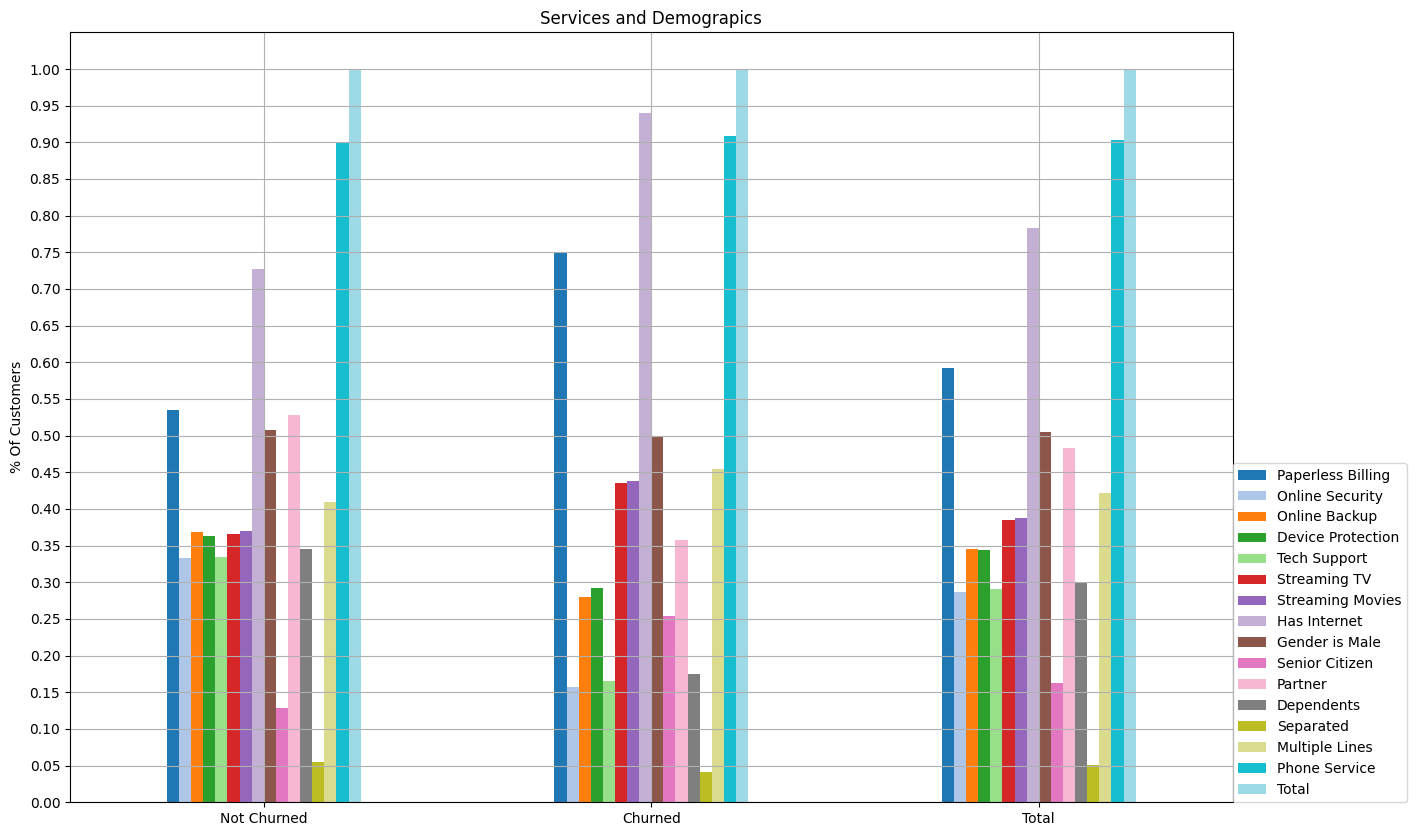

In [16]:
# Creating comparison table
compare = EDA_df.groupby('churn').sum().drop(['monthly_charges', 'total_charges', 'over_charges'], axis=1)
compare['total'] = [len(not_churn), len(churn)]
compare.loc[2] = compare.loc[0]+compare.loc[1]
compare.loc[0] = compare.loc[0]/len(not_churn)
compare.loc[1] = compare.loc[1]/len(churn)
compare.loc[2] = compare.loc[2]/len(EDA_df)

# Creating legend
titles = ['Paperless Billing', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Has Internet', 'Gender is Male', 'Senior Citizen', 'Partner', 'Dependents', 'Separated', 'Multiple Lines', 'Phone Service', 'Total']

# Comparison Plot
compare.plot(kind='bar', figsize=(15,10), style='seaborn', grid=True, colormap='tab20')
plt.legend(labels=titles, loc=(1,0))
plt.xticks(ticks=[0,1,2],labels=['Not Churned', 'Churned', 'Total'], rotation=0)
plt.yticks(np.arange(0,1.01,0.05))
plt.xlabel('')
plt.ylabel('% Of Customers')
plt.title('Services and Demograpics')
plt.show()

**Phone Data:**
- Data indicates a slightly higher rate of multiple lines in the churn data but otherwise not much difference from Total.

**Personal Data:**
- Gender is even between all 3 graphs.
- There is a higher number of senior citizens that have churned, perhaps senior citizen outreach programs can be implemented.
- Users with family (Partner/Dependents) tend tobe less likely to churn. 

**Internet Data:**
- Users who have signed up for paperless billing are at a much higher risk of churning.
- Online Security, Online Backup, Device Protection, and Tech Support are all services that assist customer loyalty.
- Streaming services have a slight trend towards churn.
- An abnormal percent of churned users had internet services. This will be looked into furthur.

### Data to be encoded

The next three graphs will compare the columns in the dataset that have not been encoded.

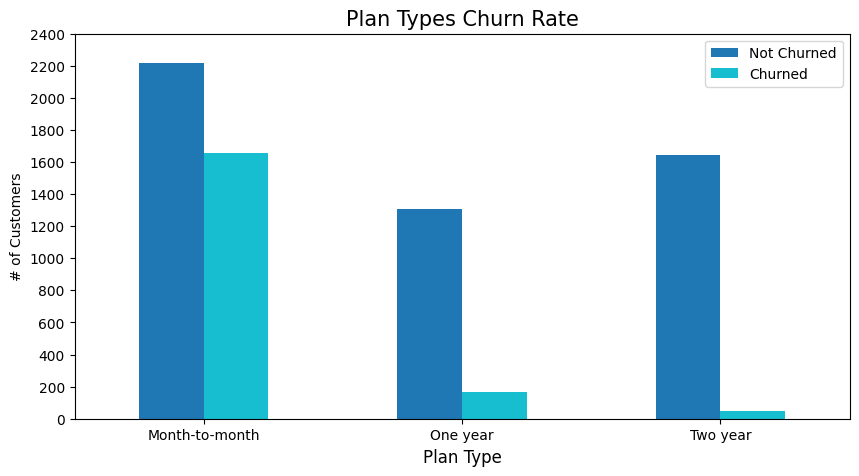

In [17]:
# Plan Type Plot
plan_type = EDA_df.pivot_table(index='type', columns='churn', values='customer_id', aggfunc='count')
plan_type.plot(kind='bar', colormap='tab10', rot=0, figsize=(10,5), yticks=np.arange(0, 2401, 200))
plt.title('Plan Types Churn Rate', fontsize=15)
plt.xlabel('Plan Type', fontsize=12)
plt.ylabel('# of Customers')
plt.legend(labels=['Not Churned', 'Churned'])
plt.show()

The Month-to-month plan type has the majority of churned users, which strengthens the idea that long term customers are less likely to leave the service. One Year and Two Year plans also tend to have better deals for customers, and the [Contract Durations](#loyalty) graph indicates there is around 6 years of user data allowing time for potential churn.

The next graph will look at the `payment_method` column:

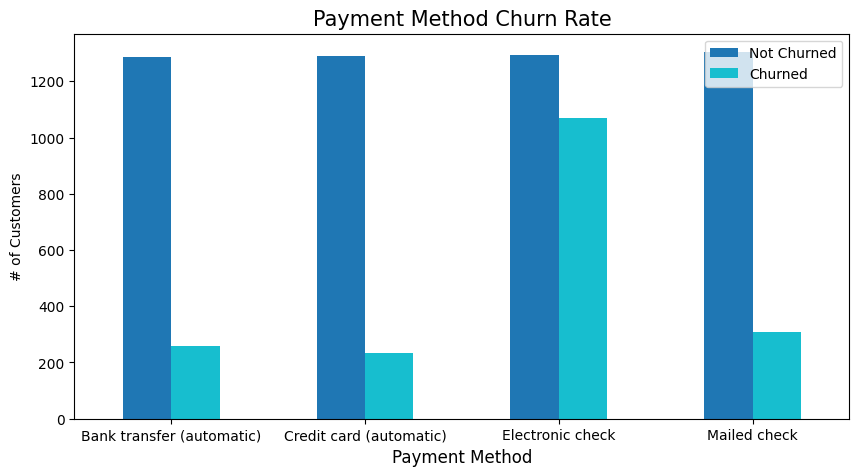

In [18]:
# Payment Method Plot
payment_type = EDA_df.pivot_table(index='payment_method', columns='churn', values='customer_id', aggfunc='count')
payment_type.plot(kind='bar', colormap='tab10', rot=0, figsize=(10,5))
plt.title('Payment Method Churn Rate', fontsize=15)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('# of Customers')
plt.legend(labels=['Not Churned', 'Churned'])
plt.show()

This graph indicates an abnormal churn rate in users who pay via Electronic Check. Users should be incentivised away from this payment method.

The next graph will look at the `internet_service` column:

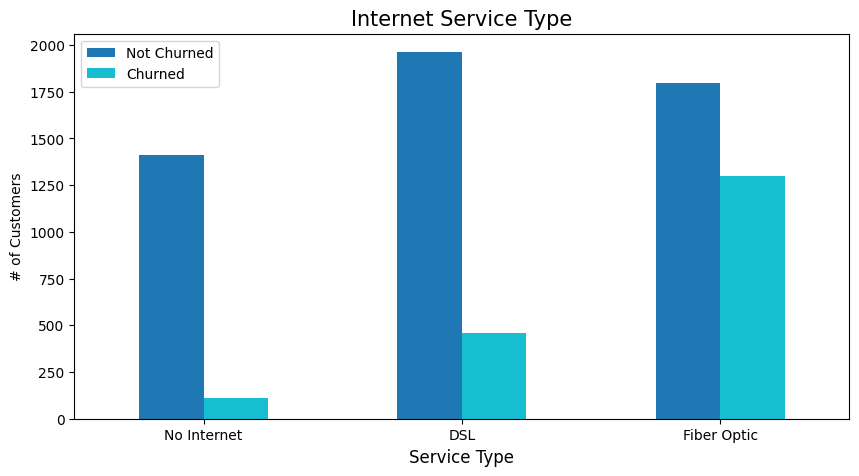

In [19]:
# Internet Service Plot
internet_type = EDA_df.pivot_table(index='internet_service', columns='churn', values='customer_id', aggfunc='count')
internet_type.plot(kind='bar', colormap='tab10', rot=0, figsize=(10,5))
plt.title('Internet Service Type', fontsize=15)
plt.xticks([0,1,2], labels=['No Internet','DSL','Fiber Optic'])
plt.xlabel('Service Type', fontsize=12)
plt.ylabel('# of Customers')
plt.legend(labels=['Not Churned', 'Churned'])
plt.show()

This graph shows that though not having internet is the minority, the Fiber Optic option has a very high churn rate. Perhaps there are issues with this service, or customers are unhappy with it is some way.

## Data Preparation

The data will be rejoined with features encoded to allow all the features to be used in training. Users not in the internet dataset will have the missing value filled in with 'No Service' to differentiate them from the other users before encoding.

In [20]:
# Initailizing Encoder
encoder = OrdinalEncoder(dtype=np.int32)

# Merging data for ML
full_data = contract.merge(internet, how='left', on='customer_id').merge(personal, how='left', on='customer_id').merge(phone, how='left', on='customer_id')
full_data['internet_service'] = full_data['internet_service'].fillna('No Service')
full_data[['type', 'payment_method', 'internet_service']] = encoder.fit_transform(full_data[['type', 'payment_method','internet_service']])

# Fill Misc. Null Values
full_data = full_data.fillna(0)
full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   int64         
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   int64         
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   over_charges       7043 non-null   float64       
 9   churn              7043 non-null   int64         
 10  internet_service   7043 non-null   int64         
 11  online_security    7043 non-null   float64       
 12  online_backup      7043 non-null   float64       
 13  device_protection  7043 non-null   float64       
 14  tech_sup

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,over_charges,churn,...,streaming_tv,streaming_movies,has_internet,gender_male,senior_citizen,partner,dependents,separated,multiple_lines,phone_service
0,7590-VHVEG,2020-01-01,No,0,1,2,29.85,29.85,0.00,0,...,0.0,0.0,1.0,0,0,1,0,0,0.0,0.0
1,5575-GNVDE,2017-04-01,No,1,0,3,56.95,1889.50,-46.80,0,...,0.0,0.0,1.0,1,0,0,0,0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,3,53.85,108.15,0.45,1,...,0.0,0.0,1.0,1,0,0,0,0,0.0,1.0
3,7795-CFOCW,2016-05-01,No,1,0,0,42.30,1840.75,-62.75,0,...,0.0,0.0,1.0,1,0,0,0,0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,2,70.70,151.65,10.25,1,...,0.0,0.0,1.0,0,0,0,0,0,0.0,1.0


### Evaluation Function

The following function will be applied to every model to graph each metric and display results

In [21]:
### Evalution Function
def evaluate_model(model, train_features, train_target, up_features, up_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for data_type, features, target in (('train', train_features, train_target), ('upscaled', up_features, up_target), ('test', test_features, test_target)):
        
        eval_stats[data_type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps
        
        if data_type == 'train':
            color = 'blue'
        elif data_type == 'test':
            color = 'red'
        else:
            color = 'green'
            
        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[data_type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
           
    return df_eval_stats

With the evaluation function defined, The data will be split at a 4:1 ratio to ensure the data can preform well with new data. Then the ML features and target will be defined for training and test sets.

In [23]:
train, test = train_test_split(full_data, test_size=0.2, random_state=12345) 

X_train = train.drop(['customer_id', 'begin_date', 'end_date', 'churn'], axis=1)
y_train = train['churn']
X_test = test.drop(['customer_id', 'begin_date', 'end_date', 'churn'], axis=1)
y_test = test['churn']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5634, 21) (5634,)
(1409, 21) (1409,)


### Class Balance

As addressed in the work plan, class balance must be addressed.

In [24]:
display(y_train.value_counts())
display(1483/len(y_train))
display(y_test.value_counts())
display(386/len(y_test))

0    4144
1    1490
Name: churn, dtype: int64

0.26322328718494853

0    1030
1     379
Name: churn, dtype: int64

0.2739531582682754

We can see that both datasets have around 0.26-0.27% churn rate. We will attempt to balance the classes both here with and upsample function and during training using the `class_weights` hyperparameter.

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 3)

print(y_upsampled.value_counts())
X_upsampled.shape, y_upsampled.shape

1    4470
0    4144
Name: churn, dtype: int64


((8614, 21), (8614,))

### Data Scaling

The data will be scaled by the StandardScaler class from sklearn to ensure optimal training and test environments, keeping in mind not to allow data leakage.

In [26]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_upsampled = pd.DataFrame(scaler.transform(X_upsampled), columns=X_upsampled.columns)
display(X_train.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,over_charges,internet_service,online_security,online_backup,device_protection,...,streaming_tv,streaming_movies,has_internet,gender_male,senior_citizen,partner,dependents,separated,multiple_lines,phone_service
0,0.369621,-1.216451,-1.463351,0.227892,-0.349146,-0.125257,-1.182729,-0.631709,1.385341,1.375032,...,-0.789111,1.24148,0.524356,-1.009990,2.266551,1.035048,-0.649346,-0.234641,1.160397,0.329904
1,-0.831328,0.822063,0.404249,0.307749,-0.812519,0.096875,0.174122,1.583007,-0.721844,-0.727256,...,-0.789111,-0.80549,0.524356,-1.009990,2.266551,-0.966139,-0.649346,-0.234641,-0.861774,0.329904
2,-0.831328,0.822063,0.404249,0.548983,-0.908724,-0.150516,0.174122,-0.631709,1.385341,-0.727256,...,-0.789111,-0.80549,0.524356,0.990109,2.266551,-0.966139,-0.649346,-0.234641,1.160397,0.329904
3,0.369621,0.822063,-1.463351,0.367642,-0.325804,-0.652728,-1.182729,1.583007,-0.721844,-0.727256,...,1.267249,1.24148,0.524356,0.990109,-0.441199,1.035048,1.540011,-0.234641,1.160397,0.329904
4,1.570570,-1.216451,1.338049,-1.301034,-0.677558,-0.630441,1.530973,-0.631709,-0.721844,-0.727256,...,-0.789111,-0.80549,-1.907102,0.990109,-0.441199,1.035048,1.540011,-0.234641,1.160397,0.329904


## Model Training
All 6 models will be cross validated by the same KFold instance.

In [27]:
# Initializing KFold
cross_validator = KFold(n_splits=5, shuffle=True, random_state=12345)

### Dummy Model (Sanity Check)

DummyClassifier(constant=1, random_state=12345, strategy='stratified')


,train,upscaled,test
Accuracy,0.61,0.49,0.61
F1,0.27,0.35,0.26
APS,0.27,0.52,0.27
ROC AUC,0.50,0.50,0.50


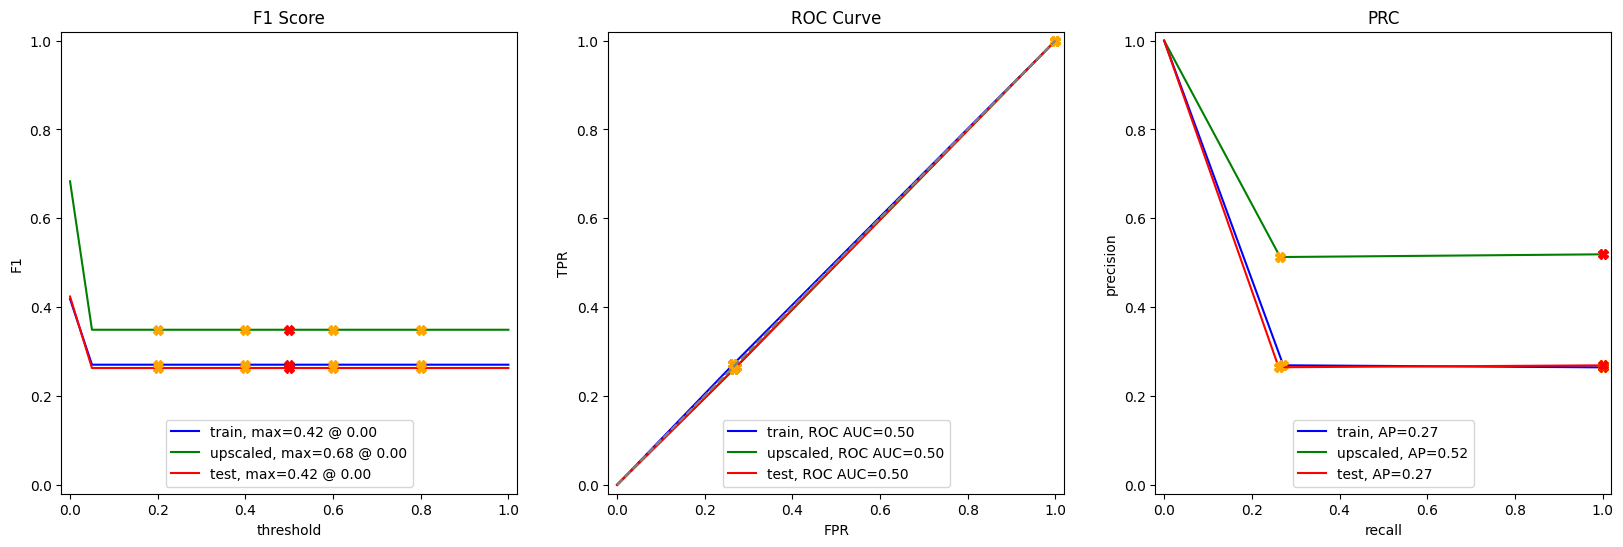

In [28]:
dummy_params = {
    'strategy':['most_frequent', 'prior', 'stratified', 'uniform', 'constant'],
    'constant':[1]
}

dummy_model = DummyClassifier(random_state=12345)
dummy_grid = GridSearchCV(dummy_model, dummy_params, scoring='roc_auc', cv=cross_validator)
dummy_grid.fit(X_train, y_train)

print(dummy_grid.best_estimator_)
dummy_eval = evaluate_model(dummy_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(dummy_eval)

DummyClassifier(constant=1, random_state=12345, strategy='stratified')


,train,upscaled,test
Accuracy,0.49,0.50,0.49
F1,0.35,0.52,0.35
APS,0.26,0.52,0.27
ROC AUC,0.50,0.50,0.50


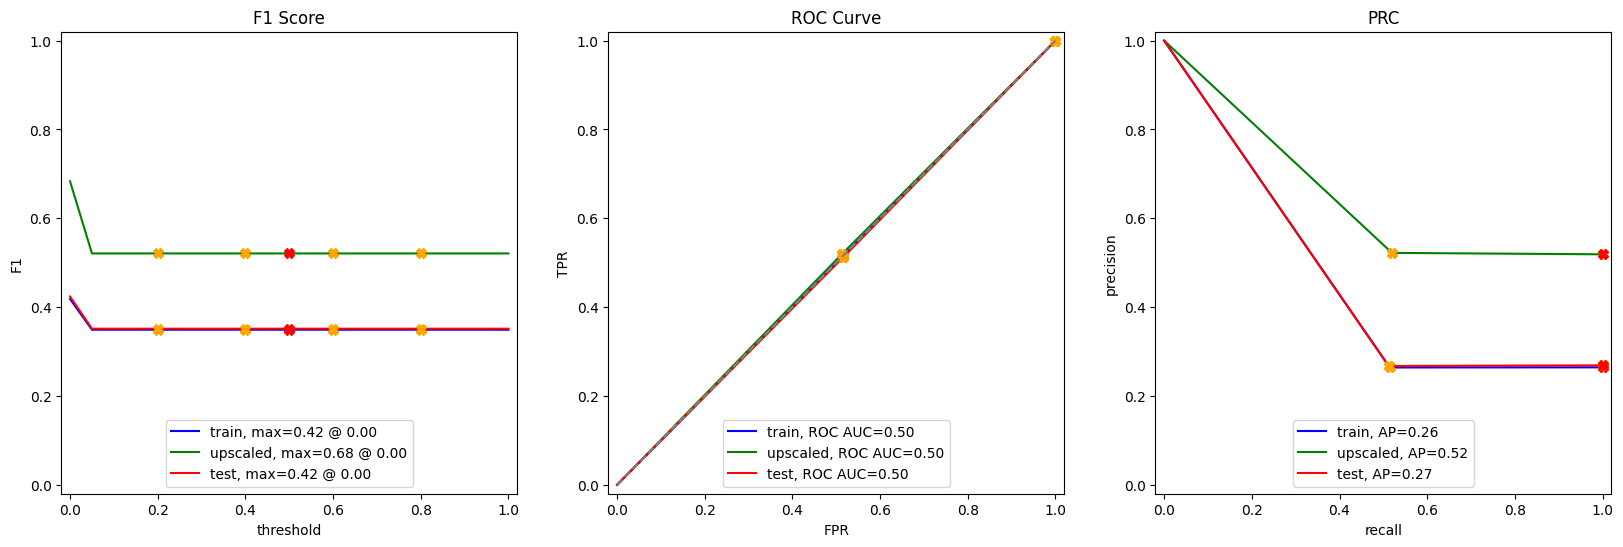

In [29]:
dummy_model_up = DummyClassifier(random_state=12345)
dummy_grid_up = GridSearchCV(dummy_model, dummy_params, scoring='roc_auc', cv=cross_validator)
dummy_grid_up.fit(X_upsampled, y_upsampled)

print(dummy_grid_up.best_estimator_)
dummy_eval_up = evaluate_model(dummy_grid_up, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(dummy_eval_up)

The dummy models preform at 0.5 coth in ROC AUC and Accuracy as expected.

### Logistic Regression Model

{'max_iter': 10000, 'n_jobs': -1, 'solver': 'sag'}


,train,upscaled,test
Accuracy,0.75,0.77,0.75
F1,0.63,0.78,0.63
APS,0.64,0.83,0.65
ROC AUC,0.84,0.84,0.84


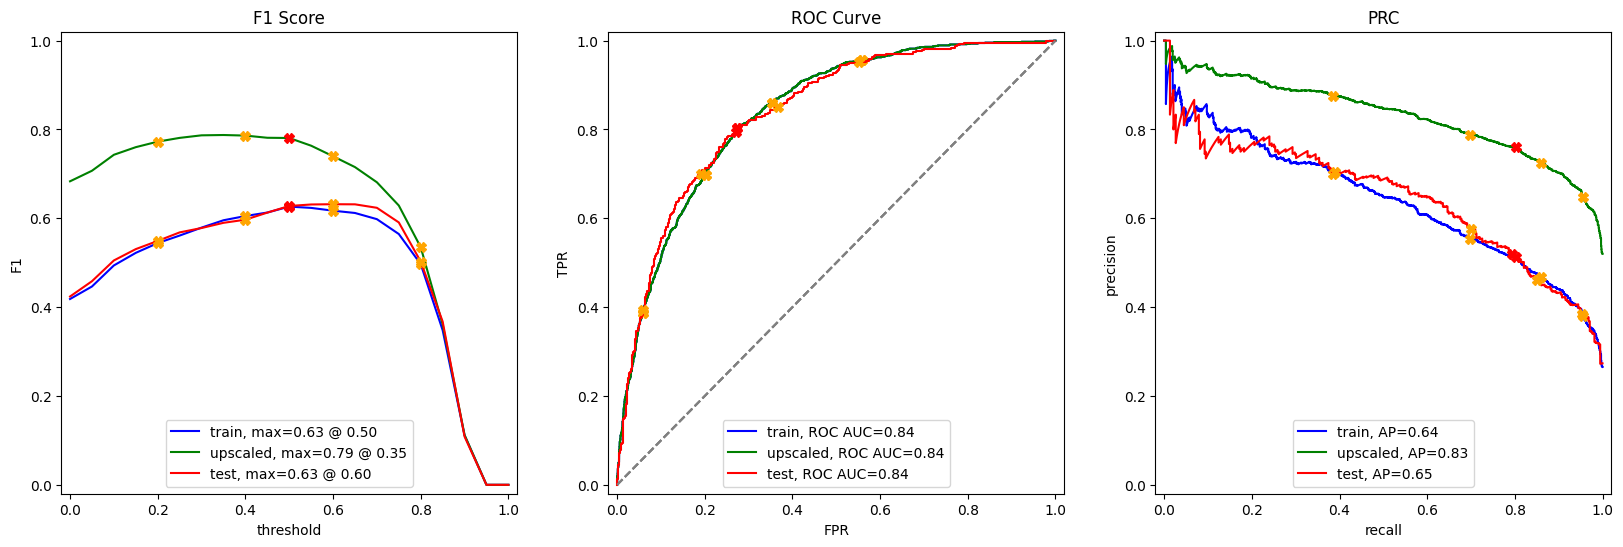

In [30]:
logreg_params = {
    'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
    'n_jobs':[-1],
    'max_iter':[10000]
}

logreg_model = LogisticRegression(random_state=12345, class_weight='balanced')
logreg_grid = GridSearchCV(logreg_model, logreg_params, scoring='roc_auc', cv=cross_validator)
logreg_grid.fit(X_train, y_train)

print(logreg_grid.best_params_)
logreg_eval = evaluate_model(logreg_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(logreg_eval)

{'max_iter': 10000, 'n_jobs': -1, 'solver': 'saga'}


,train,upscaled,test
Accuracy,0.75,0.77,0.75
F1,0.63,0.78,0.63
APS,0.64,0.83,0.65
ROC AUC,0.84,0.84,0.84


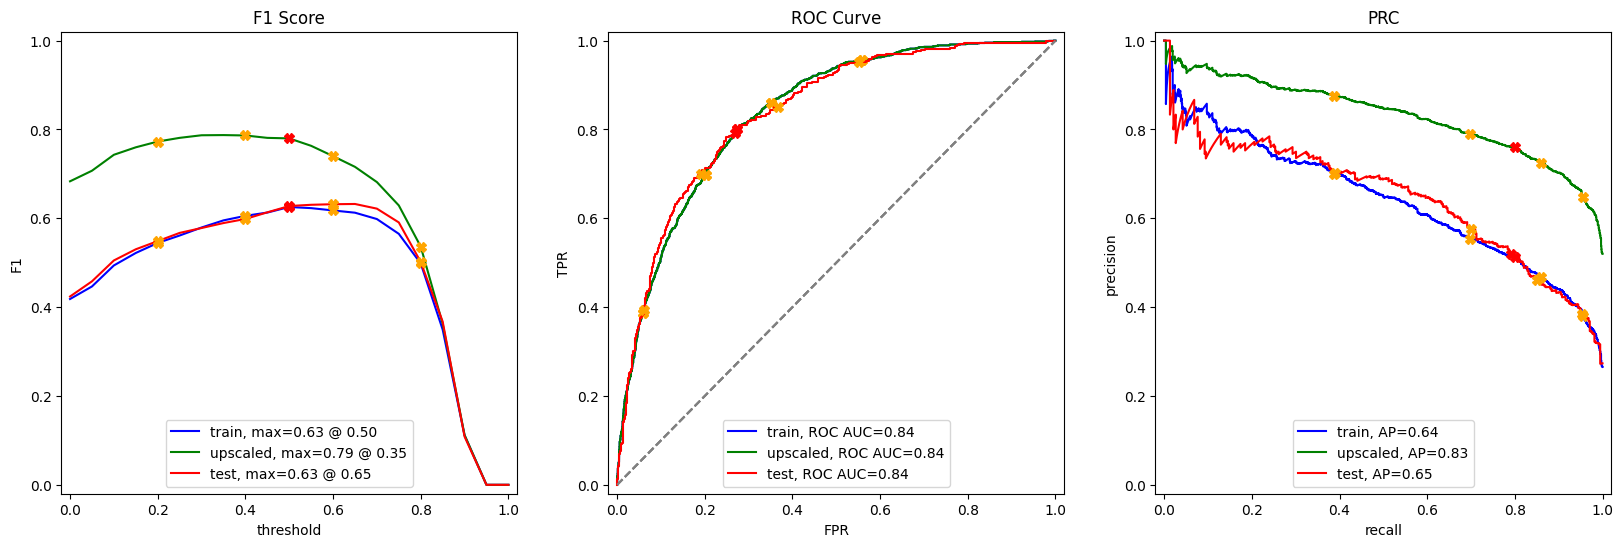

In [31]:
logreg_model_up = LogisticRegression(random_state=12345)
logreg_grid_up = GridSearchCV(logreg_model, logreg_params, scoring='roc_auc', cv=cross_validator)
logreg_grid_up.fit(X_upsampled, y_upsampled)

print(logreg_grid_up.best_params_)
logreg_eval_up = evaluate_model(logreg_grid_up, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(logreg_eval_up)

Both Logistic Regression models preform well with both datasets, almost identical.

### Decision Tree Model

{'max_depth': 5, 'min_samples_split': 2}


,train,upscaled,test
Accuracy,0.73,0.78,0.71
F1,0.63,0.80,0.62
APS,0.63,0.82,0.59
ROC AUC,0.85,0.85,0.83


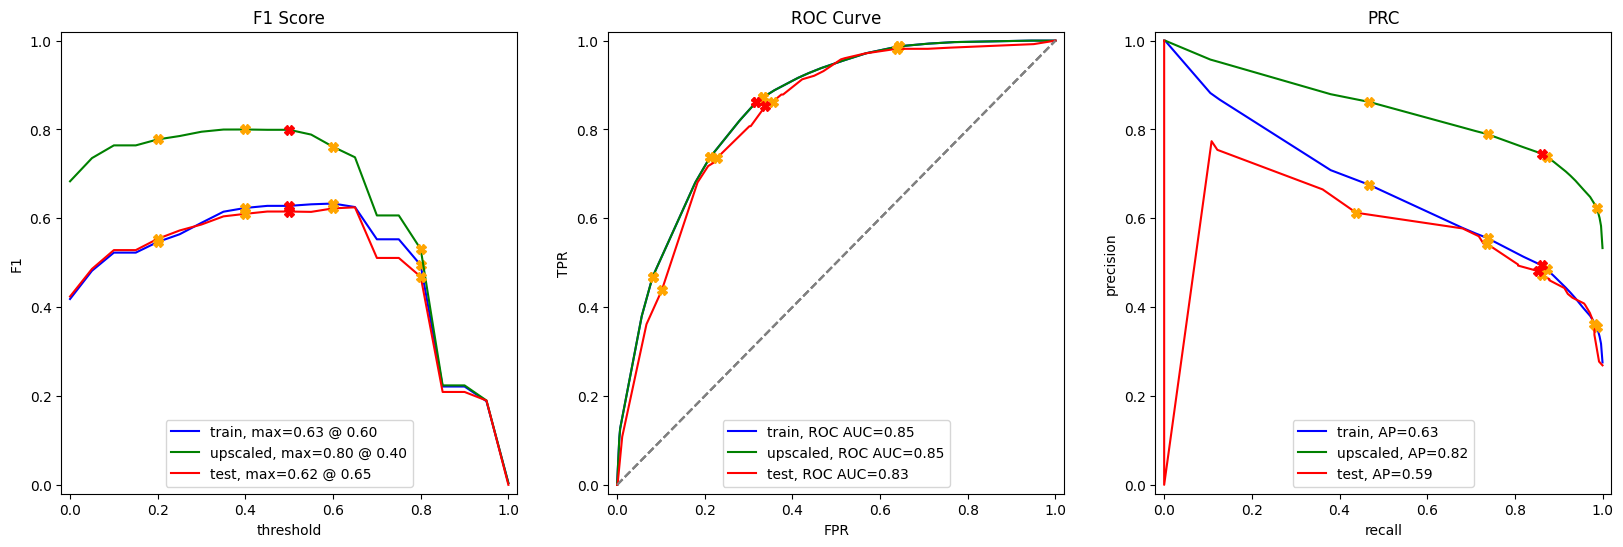

In [32]:
tree_params = {
    'max_depth':np.arange(1,31,1),
    'min_samples_split':[2,4,6,8,10]
}

tree_model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
tree_grid = GridSearchCV(tree_model, tree_params, scoring='roc_auc', cv=cross_validator)
tree_grid.fit(X_train, y_train)

print(tree_grid.best_params_)
tree_eval = evaluate_model(tree_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(tree_eval)

{'max_depth': 29, 'min_samples_split': 2}


,train,upscaled,test
Accuracy,1.0,1.0,0.73
F1,1.0,1.0,0.50
APS,1.0,1.0,0.38
ROC AUC,1.0,1.0,0.66


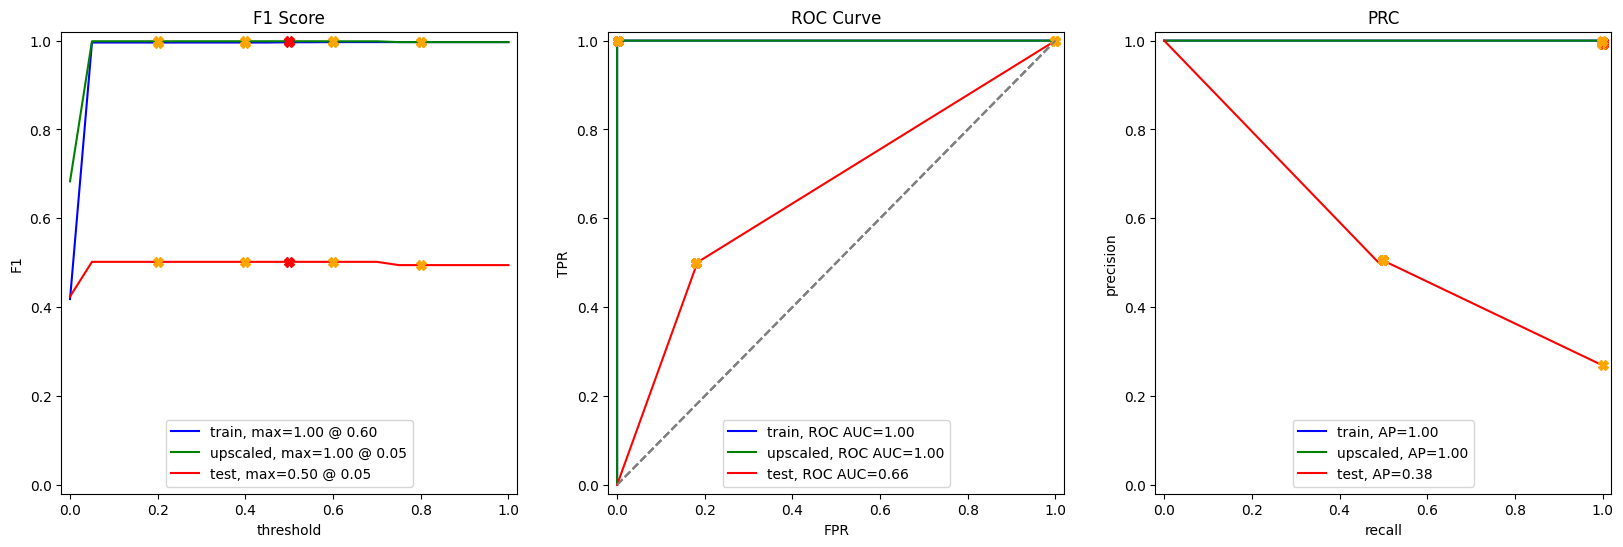

In [33]:
tree_model_up = DecisionTreeClassifier(random_state=12345)
tree_grid_up = GridSearchCV(tree_model, tree_params, scoring='roc_auc', cv=cross_validator)
tree_grid_up.fit(X_upsampled, y_upsampled)

print(tree_grid_up.best_params_)
tree_eval_up = evaluate_model(tree_grid_up, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(tree_eval_up)

The Decision Tree model does not seem like a good fit for this task, it preformed worse than the Logistic Regression model with the normal training data and while the model seems to preform well when trained with the upsamlpled data, the test graph shows some kind of issue.

### Random Forest Model

{'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 1000}


,train,upscaled,test
Accuracy,0.80,0.82,0.76
F1,0.69,0.83,0.64
APS,0.75,0.89,0.66
ROC AUC,0.90,0.90,0.85


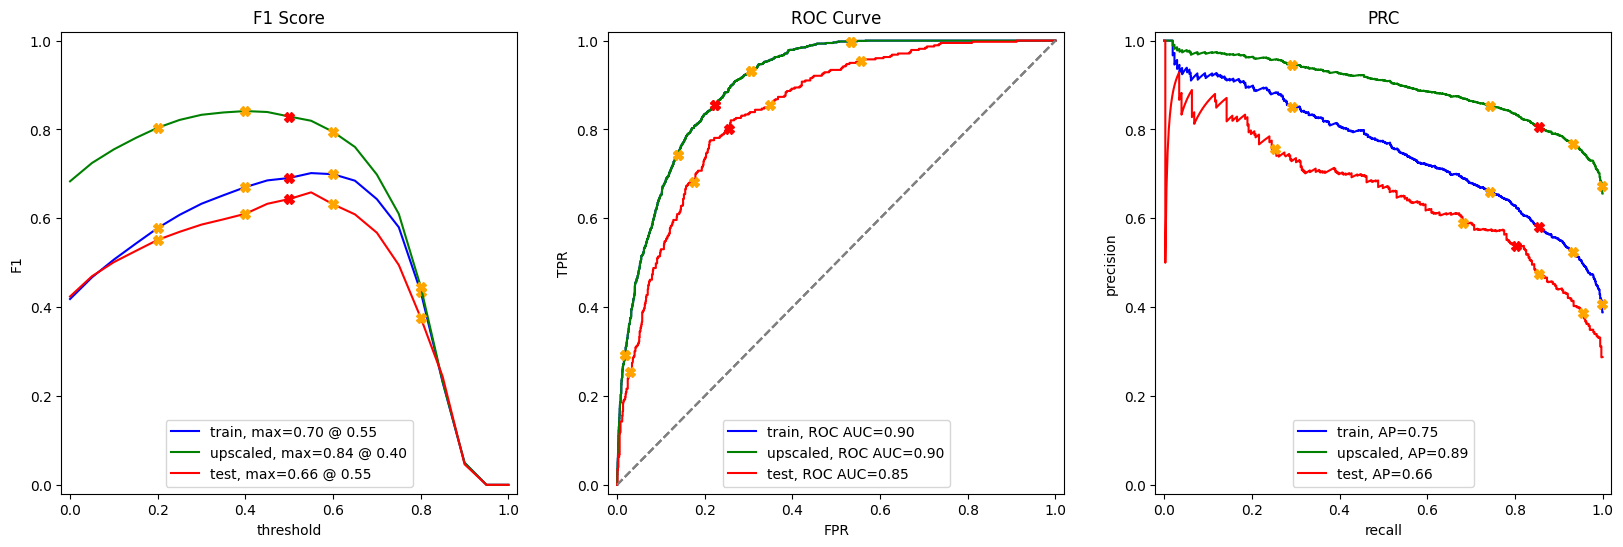

In [34]:
forest_params = {
    'n_estimators':[1000, 1500],
    'max_depth':np.arange(6,25,2),
    'min_samples_split':[2,6]
}

forest_model = RandomForestClassifier(random_state=12345, class_weight='balanced')
forest_grid = GridSearchCV(forest_model, forest_params, scoring='roc_auc', cv=cross_validator)
forest_grid.fit(X_train, y_train)

print(forest_grid.best_params_)
forest_eval = evaluate_model(forest_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(forest_eval)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 1500}


,train,upscaled,test
Accuracy,1.00,1.0,0.78
F1,0.99,1.0,0.60
APS,1.00,1.0,0.61
ROC AUC,1.00,1.0,0.83


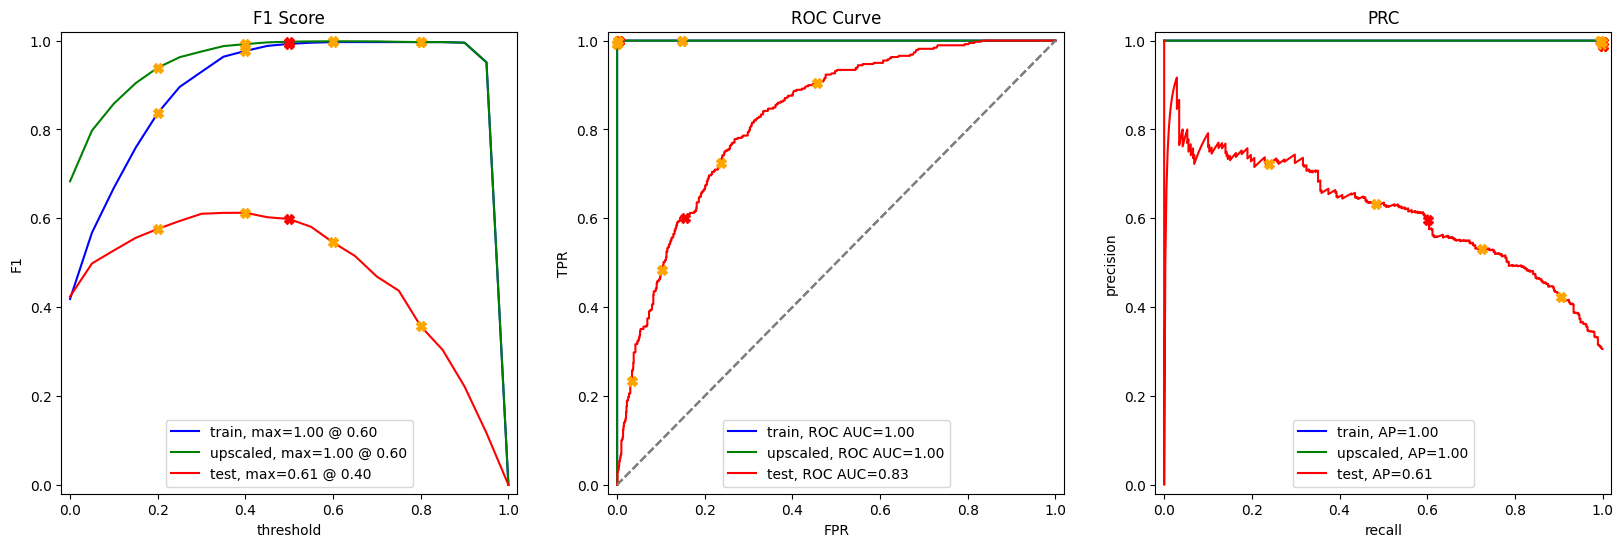

In [35]:
forest_model_up = RandomForestClassifier(random_state=12345)
forest_grid_up = GridSearchCV(forest_model, forest_params, scoring='roc_auc', cv=cross_validator)
forest_grid_up.fit(X_upsampled, y_upsampled)

print(forest_grid_up.best_params_)
forest_eval_up = evaluate_model(forest_grid_up, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(forest_eval_up)

The Random Forest model train on the normal training data managed to achieve the target ROC-AUC of 0.85, out preforming all other models thus far. The model trained on upsampled data seems to suffer from the same issue as the Decision Tree but still managed to score a ROC-AUC of 0.83.

### LightGBM Classifier Model

{'learning_rate': 0.03, 'num_leaves': 31}


,train,upscaled,test
Accuracy,0.80,0.82,0.76
F1,0.70,0.84,0.64
APS,0.75,0.89,0.65
ROC AUC,0.90,0.90,0.84


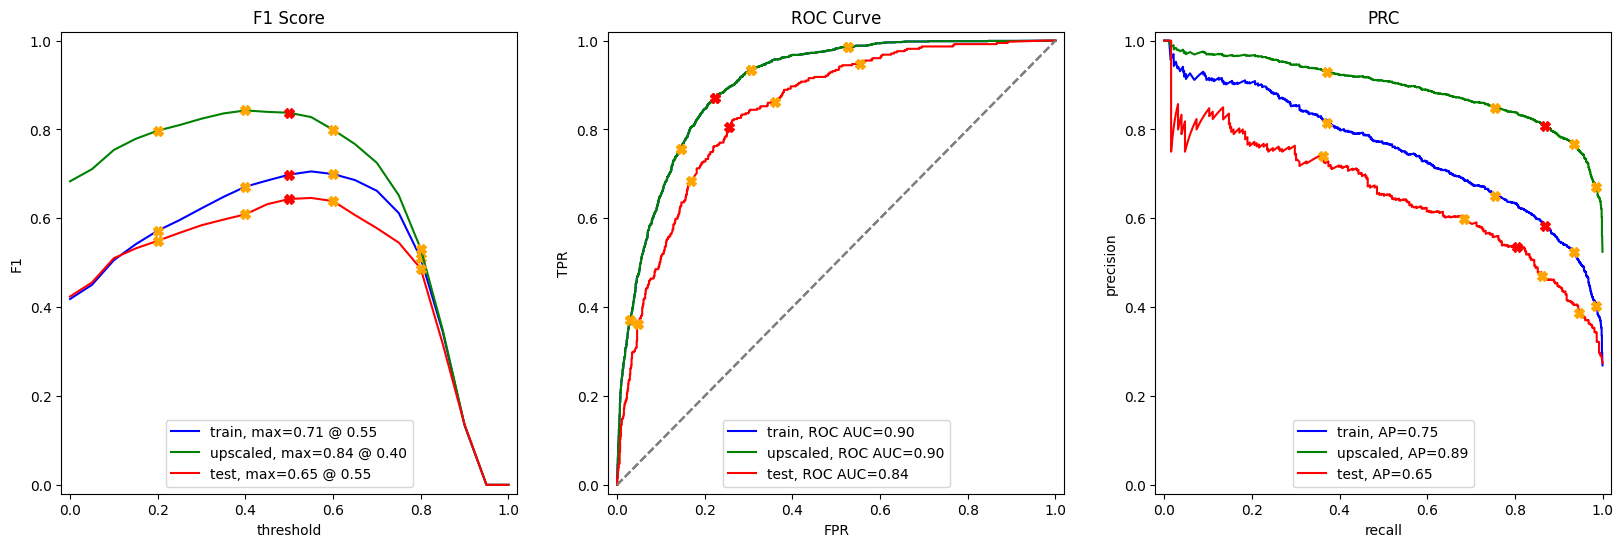

In [36]:
lightgbm_params = {
    'num_leaves':[31, 100, 300],
    'learning_rate':[0.03, 0.01]
}

lightgbm_model = LGBMClassifier(random_state=12345, class_weight='balanced')
lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, scoring='roc_auc', cv=cross_validator)
lightgbm_grid.fit(X_train, y_train)

print(lightgbm_grid.best_params_)
lightgbm_eval = evaluate_model(lightgbm_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(lightgbm_eval)

{'learning_rate': 0.03, 'num_leaves': 300}


,train,upscaled,test
Accuracy,0.95,0.96,0.76
F1,0.91,0.97,0.61
APS,0.98,0.99,0.63
ROC AUC,0.99,0.99,0.82


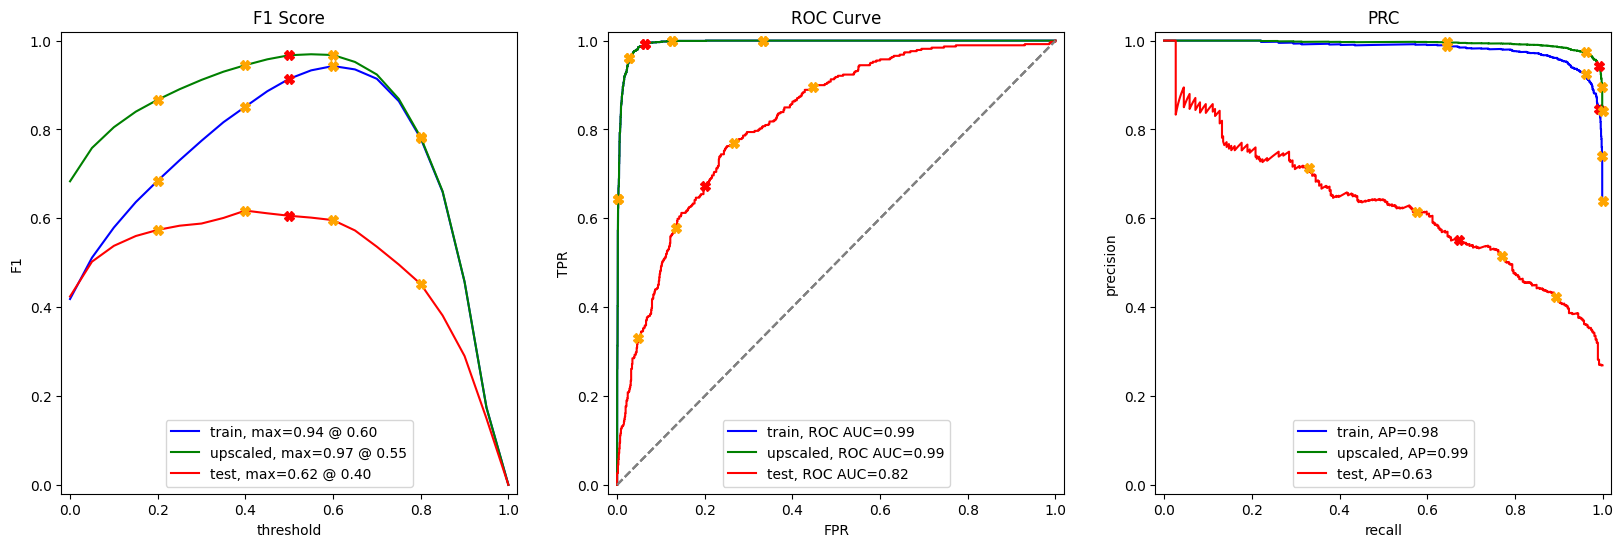

In [37]:
lightgbm_model_up = LGBMClassifier(random_state=12345)
lightgbm_grid_up = GridSearchCV(lightgbm_model, lightgbm_params, scoring='roc_auc', cv=cross_validator)
lightgbm_grid_up.fit(X_upsampled, y_upsampled)

print(lightgbm_grid_up.best_params_)
lightgbm_eval_up = evaluate_model(lightgbm_grid_up, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(lightgbm_eval_up)

The Light GBM model seems to not handle the data as well as other Gradient Boosting methods. This could be due to any number of factors though it still preformed competitively to the other models, and still well outpreformed the sanity check. 

### Catboost Classifier Model

{'iterations': 2000, 'max_depth': 2, 'verbose': False}


,train,upscaled,test
Accuracy,0.76,0.79,0.74
F1,0.65,0.80,0.63
APS,0.70,0.86,0.65
ROC AUC,0.87,0.87,0.85


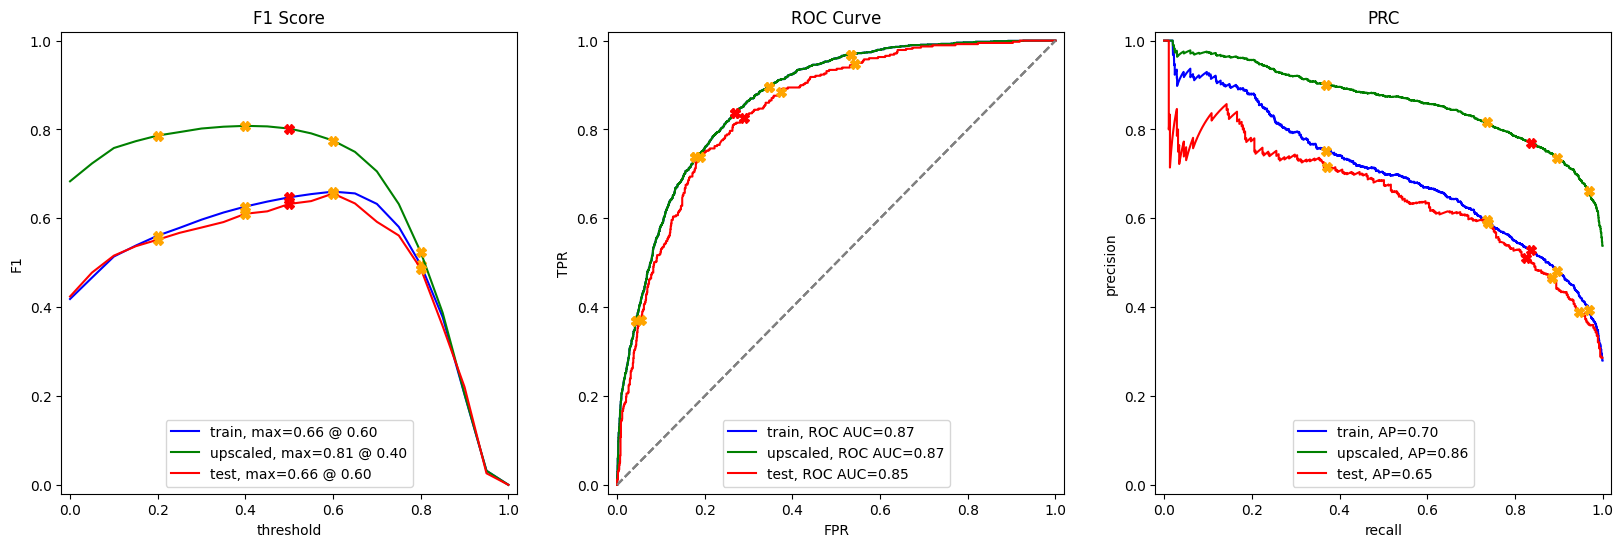

In [38]:
catboost_params = {
    'iterations':[2000, 2500],
    'max_depth': np.arange(1,11,1),
    'verbose':[False]
}

catboost_model = CatBoostClassifier(random_state=12345, auto_class_weights='Balanced')
catboost_grid = GridSearchCV(catboost_model, catboost_params, scoring='roc_auc', cv=cross_validator)
catboost_grid.fit(X_train, y_train)

print(catboost_grid.best_params_)
catboost_eval = evaluate_model(catboost_grid, X_train, y_train, X_upsampled, y_upsampled, X_test, y_test)
display(catboost_eval)

{'iterations': 2500, 'max_depth': 10, 'verbose': False}


,train,upscaled,test
Accuracy,0.98,0.99,0.76
F1,0.97,0.99,0.58
APS,1.00,1.00,0.63
ROC AUC,1.00,1.00,0.82


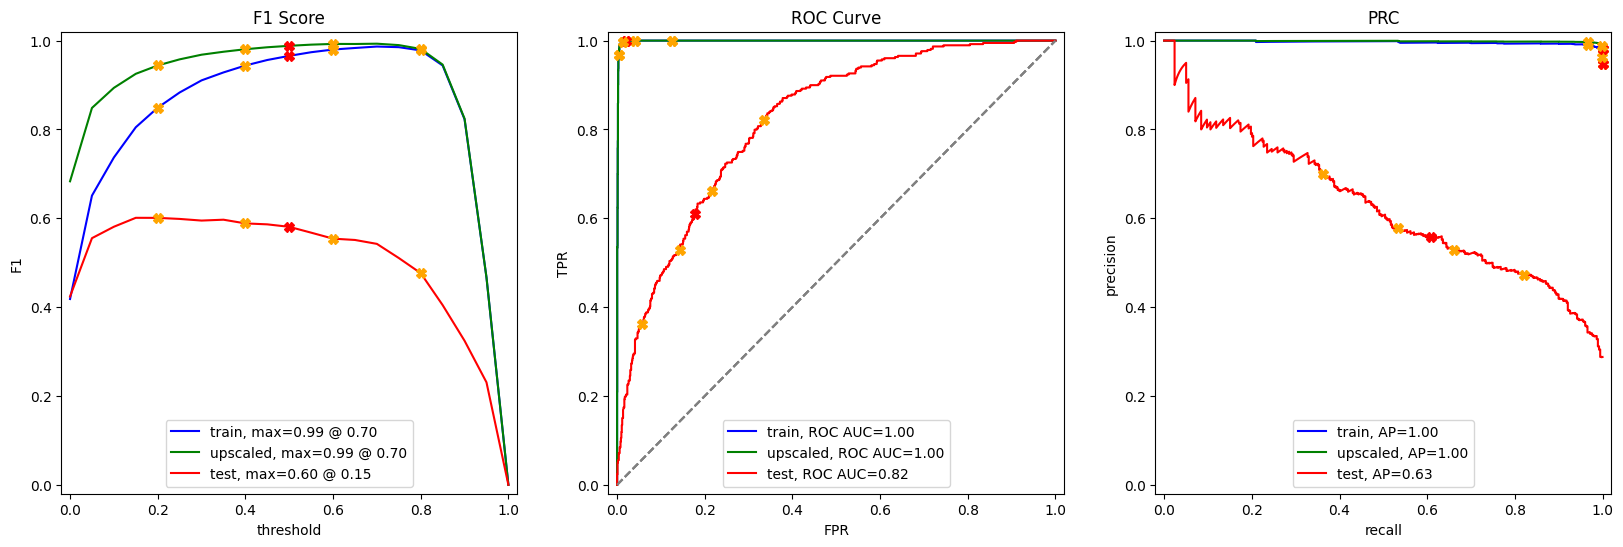

In [39]:
catboost_model_up = CatBoostClassifier(random_state=12345)
catboost_grid_up = GridSearchCV(catboost_model, catboost_params, scoring='roc_auc', cv=cross_validator)
catboost_grid_up.fit(X_upsampled, y_upsampled)

print(catboost_grid_up.best_params_)
catboost_eval_up = evaluate_model(catboost_grid_up, X_train, y_train, X_upsamplef

The CatBoost model trained on the normal training data also achieved the target ROC-AUC of 0.85, making it also a viable model for use by Interconnect. The model trained on the upsampled data contines to achieve perfect scores but fall behind during testing. 

## Conclusion

In analysing the user data provided by Interconnect, we were able to make important discoveries about user behaviour and the quality of services offered by the provider. Users who are likely to churn will to so within half a year to a year, leaving a relatively small window for promotional materials. The majority of customers who have not churned have a long history with Interconnect and tend to have plans with longer renewal periods. These usuers also tend to have very low monthly rates, which is likely due to the prevalence of longer plans. 

The majority of users have phone service, and the churn rate seems negligible, phone services should be prioritized. Demographic data indicates that senior citizens are more likely to churn, but that users with family (i.e. Has Spouse/Dependents) are less likely to churn. Senior Citizen outreach programs may promote loyalty. 

Online Security, Online Backup, Device Protection, and Tech Support services all decrease churn rate and should be included in promotional materials. The data indicates a high churn rate with users signed up for Fiber Optic internet services, perhaps there are issues with connectivity or other problems causing this, I recommend more research into this. The data also indicates high churn rates with both users signed up for paperless billing and users who pay via electronic check, perhaps this could indicate issues with UX on Interconnect's website. 

The Random Forest and CatBoost models are recommended for use by Interconnect for the prediction of churn rates.

# Solution Report

1. What steps of the plan were performed and what steps were skipped (explain why)?
    - All steps of the plan were preformed as submitted.

2. What difficulties did you encounter and how did you manage to solve them?
    - Wanted to ensure the tenure variable did not cause data leakage. Left it out of the table. 
    - As noted `total_charges` had missing values.
    - Gender column had incorrect values when included in the original OHE call.
    - Models did not train well on upsampled data, as noted. Included training on original data with class weight adjustments.

3. What were some of the key steps to solving the task?
    - Hyperparameter Tuning
    - Proper encoding, then scaling
    - Avoiding data leakage

4. What is your final model and what quality score does it have?
    - Random Forest Classifier: 
        - ROC-AUC: 0.85
        - Accuracy: 0.76
    - CatBoost Classifier:
        - ROC-AUC: 0.85
        - Accuracy: 0.74